In [5]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import strax

In [6]:
# # Create a file with 300MB uncompressed data, which is 18.3% of the total data
# # (the whole thing is > GB, which will probably cause swapping on my laptop)
# import strax
# records = strax.frompax.pax_to_records('./180215_1029')
# f_stored = 300e6 / records.nbytes
# records = records[:int(len(records) * f_stored)]
# strax.save('triggerless_300MB.bin', records, compressor='blosc')
# print(f_stored)

In [7]:
zlib_pickles_reduction = (684e6 * 0.183) /300e6 
zlib_pickles_time = 121 * 0.183

In [16]:
records = strax.load('tl_z')
records_raw = records.copy()
strax.process.baseline(records)
strax.cut_baseline(records)

## Benchmark compressions

In [17]:
import contexttimer as ctt
import os
from functools import partial

# Add suboptimal compressors
import snappy
import zlib
strax.data.COMPRESSORS.update(dict(
    # zlib 4 matches level used in eventbuiler
    zlib=dict(compress=partial(zlib.compress, level=4), decompress=zlib.decompress),
    snappy=dict(compress=partial(snappy.compress), decompress=snappy.decompress),
))
    
# TODO n_trials

def benchmark_compression(records):
    comp_results = dict()

    for comp in ['none'] + list(strax.data.COMPRESSORS.keys()):
        print(comp)
        fn = f'test_{comp}'

        save_times = []
        with ctt.Timer() as t_save:
            strax.save(fn, records, compressor=comp)
        with ctt.Timer() as t_load:
            strax.load(fn)

        r = dict()
        r['save'] = t_save.elapsed
        r['load'] = t_load.elapsed
        r['reduction'] = os.path.getsize(fn + '.' + (comp if comp != 'none' else 'npy')) / records.nbytes
        comp_results[comp] = r

        strax.delete(fn)
        
    return comp_results

comp_perf_raw = benchmark_compression(records_raw)
comp_perf_bl = benchmark_compression(records)

none
bz2
zstd
blosc
zlib
snappy
none
bz2
zstd
blosc
zlib
snappy


In [18]:
plt.style.use('latex_thesis')

/home/jelle/anaconda3/envs/36/lib/python3.6/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


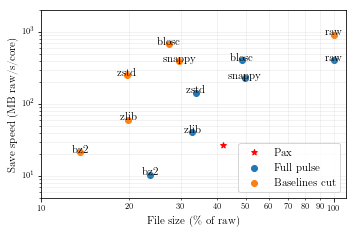

In [21]:
plt.scatter([100 * zlib_pickles_reduction], [300/zlib_pickles_time*2],   #*2 since save + load
            marker='*', color='red', label='Pax')

for cp, label in ([comp_perf_raw, 'Full pulse'], [comp_perf_bl, 'Baselines cut']):
    
    df = pd.DataFrame(cp).T
    x = 100 * df['reduction']
    y = 300/df['save']

    plt.scatter(x, y, label=label)
    for i in range(len(df)):
        comp = df.index[i]
        plt.annotate(comp if comp != 'none' else 'raw', 
                     (x[i], y[i]),
                     horizontalalignment='center')
        
plt.ylabel("Save speed (MB raw/s/core)")
plt.xlabel("File size (\% of raw)")
plt.yscale('log')
plt.ylim(5, 2000)
plt.grid(alpha=0.2, which='both')

plt.xscale('log')
plt.legend(loc='lower right')

xticks = list(plt.xticks()[0])
#xticks += [15]
plt.xticks(xticks)
plt.xlim(10, 110)

ax = plt.gca()
for axis in [ax.xaxis]:    
    axis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
    axis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
plt.tight_layout()
plt.savefig('compression_benchmark.pdf')

In [20]:
#strax.save('triggerless_300MB_comp', records_raw, compressor='bz2')